<a href="https://colab.research.google.com/github/fedrikkhou/fedrikkhou/blob/main/New_York_City_Traffic_Accidents_Logistic_Regression_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PREPARATION

In [ ]:
import pandas as pd                 # Library used for working with data sets and perform data analysis.
import numpy as np                  # To perform mathematical operasion and statistics
from datetime import datetime       # Used to perform dates and time manipulation
import seaborn as sns               # To perform data visualization
import matplotlib.pyplot as plt     # To perform data visualization

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
csv_source_url = 'https://drive.google.com/uc?id=1sMzgnocVp7DCwY-t4B6g9sotQNIf6bPB'
df = pd.read_csv(csv_source_url)

# DATA CLEANING

In [ ]:
df_dc = df.copy()

### Borough / Latitude + Longitude / Location

In [ ]:
#some data has location 'POINT (0 0)', and that geolocation appear in several borough
df_exclude_location00 = df_dc[~((df_dc['LOCATION'] == 'POINT (0 0)') & (df_dc['BOROUGH'].isnull()))]

df_dc["BOROUGH"] = df_exclude_location00.groupby("LOCATION")["BOROUGH"].ffill()
df_dc["ZIP CODE"] = df_exclude_location00.groupby("LOCATION")["ZIP CODE"].ffill()
df_dc["BOROUGH"] = df_dc.groupby("ZIP CODE")["BOROUGH"].ffill()

In [ ]:
#CODE to find BOROUGH for rows that still NULL
#PERSONS KILLED deleted: 55 ==> 14
#PERSONs INJURED deleted: 6781 ==> 1693
csv_additional_source_url = 'https://drive.google.com/uc?id=1f53GZfriwJJ7MV2BKlgioSzR4Oz5HYh4'
df_additional_source = pd.read_csv(csv_additional_source_url, sep=';')
df_dc = pd.merge(df_dc, df_additional_source, on='COLLISION_ID', how = 'left')

def getborough2(row):
  if (pd.isnull(row['BOROUGH']) ):
    if (pd.notnull(row['FOUND BOROUGH'])):
      return row['FOUND BOROUGH']
  else:
    return row['BOROUGH']

df_dc['BOROUGH'] = df_dc.apply(getborough2, axis=1)
df_dc[['ZIP CODE']] = df_dc[['ZIP CODE']].fillna('-')
df_dc.drop(columns = 'LOCATION2', inplace = True)
df_dc.drop(columns = 'FOUND BOROUGH', inplace = True)

Remove data with missing BOROUGH and ZIP CODE

In [ ]:
df_dc = df_dc[~df_dc['BOROUGH'].isna()]
df_dc = df_dc[~df_dc['ZIP CODE'].isna()]

### ON Street + CROSS Street + OFF Street

In [ ]:
df_dc[['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']] = df_dc[['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']].fillna('-')

In [ ]:
def typeofstreetaccident(row):
    onstreet = row['ON STREET NAME']
    crosssstreet = row['CROSS STREET NAME']
    offstreet = row['OFF STREET NAME']

    if (onstreet == '-'): #asumsi if on street null maka off street
      return 'OFF STREET'
    else:
      if(crosssstreet == '-'): #if cross street null maka on street
        return 'ON STREET'
      else:
        return 'ON CROSS STREET'

df_dc['STREET ACCIDENT TYPE'] = df_dc.apply(typeofstreetaccident, axis=1)

### Contributing Factors Vehicle 1 - 5

In [ ]:
#fill fatal accident that has
df_dc[['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2']] = df_dc[['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2']].fillna('-')

In [ ]:
#df_dc.drop(columns = 'CONTRIBUTING FACTOR VEHICLE 2', inplace = True)
df_dc.drop(columns = 'CONTRIBUTING FACTOR VEHICLE 3', inplace = True)
df_dc.drop(columns = 'CONTRIBUTING FACTOR VEHICLE 4', inplace = True)
df_dc.drop(columns = 'CONTRIBUTING FACTOR VEHICLE 5', inplace = True)

### Vehicle type code 1 - 5

In [ ]:
def getnumberofvehicle(row):
  numberofvehicle = 0
  if (pd.notnull(row['VEHICLE TYPE CODE 1'])):
    numberofvehicle = 1

  if (pd.notnull(row['VEHICLE TYPE CODE 2'])):
    numberofvehicle = numberofvehicle + 1

  if (pd.notnull(row['VEHICLE TYPE CODE 3'])):
    numberofvehicle = numberofvehicle + 1

  if (pd.notnull(row['VEHICLE TYPE CODE 4'])):
    numberofvehicle = numberofvehicle + 1

  if (pd.notnull(row['VEHICLE TYPE CODE 5'])):
    numberofvehicle = numberofvehicle + 1

  return numberofvehicle

df_dc['NUMBER OF VEHICLES'] = df_dc.apply(getnumberofvehicle, axis=1)

In [ ]:
#4 rows of fatal accident that VEHICLE TYPE CODE 1 is null filled with '-' to prevent delete
df_dc.loc[((df_dc['VEHICLE TYPE CODE 1'].isnull()) & (df_dc['NUMBER OF PERSONS KILLED'] > 0)), ['VEHICLE TYPE CODE 1']] = '-'

df_dc = df_dc[~(df_dc['VEHICLE TYPE CODE 1'].isnull())]
df_dc[['VEHICLE TYPE CODE 2']] = df_dc[['VEHICLE TYPE CODE 2']].fillna('-')

<ipython-input-12-e673ec1a30cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dc[['VEHICLE TYPE CODE 2']] = df_dc[['VEHICLE TYPE CODE 2']].fillna('-')


In [ ]:
df_dc.drop(columns = 'VEHICLE TYPE CODE 3', inplace = True)
df_dc.drop(columns = 'VEHICLE TYPE CODE 4', inplace = True)
df_dc.drop(columns = 'VEHICLE TYPE CODE 5', inplace = True)

<ipython-input-13-086059aa343c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dc.drop(columns = 'VEHICLE TYPE CODE 3', inplace = True)
<ipython-input-13-086059aa343c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dc.drop(columns = 'VEHICLE TYPE CODE 4', inplace = True)
<ipython-input-13-086059aa343c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dc.drop(columns = 'VEHICLE TYPE CODE 5', inplace = True)


##Fix Data Type

In [ ]:
df_dc['CRASH DATE'] = pd.to_datetime(df_dc['CRASH DATE'], format = '%Y-%m-%d')
df_dc['CRASH TIME'] = pd.to_datetime(df_dc['CRASH TIME'], format = '%H:%M:%S')
df_dc['ZIP CODE'] = df_dc['ZIP CODE'].astype(str)
df_dc['COLLISION_ID'] = df_dc['COLLISION_ID'].astype(str)

#LOGISTIC REGRESSION MODELLING

####a) Prepare model

In [ ]:
df_preparation = df_dc.copy()

In [ ]:
#df_propensity.drop(columns = 'COLLISION_ID', inplace = True)
df_preparation.drop(columns = 'ZIP CODE', inplace = True)
df_preparation.drop(columns = 'LATITUDE', inplace = True)
df_preparation.drop(columns = 'LONGITUDE', inplace = True)
df_preparation.drop(columns = 'LOCATION', inplace = True)
df_preparation.drop(columns = 'ON STREET NAME', inplace = True)
df_preparation.drop(columns = 'CROSS STREET NAME', inplace = True)
df_preparation.drop(columns = 'OFF STREET NAME', inplace = True)

# logistic regression cant process datetime so only the month
df_preparation['MONTH'] = df_preparation['CRASH DATE'].dt.month
df_preparation.drop(columns = 'CRASH DATE', inplace = True)
df_preparation['HOUR'] = df_preparation['CRASH TIME'].dt.hour
df_preparation.drop(columns = 'CRASH TIME', inplace = True)

categorical_columns = df_preparation.select_dtypes(include='object').columns.to_list()
categorical_columns.remove('COLLISION_ID')
df_preparation[categorical_columns]

,BOROUGH,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,STREET ACCIDENT TYPE
0,BRONX,Passing Too Closely,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,ON CROSS STREET
1,BROOKLYN,Reaction to Uninvolved Vehicle,Unspecified,Sedan,Sedan,ON CROSS STREET
2,MANHATTAN,Backing Unsafely,-,Station Wagon/Sport Utility Vehicle,-,ON STREET
3,BRONX,Unsafe Speed,Unspecified,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,OFF STREET
4,BROOKLYN,Failure to Yield Right-of-Way,Unspecified,Sedan,Sedan,OFF STREET
...,...,...,...,...,...,...
74876,BRONX,Unspecified,-,Sedan,-,OFF STREET
74877,BROOKLYN,Passing Too Closely,Unspecified,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,OFF STREET
74878,BRONX,Unspecified,Unspecified,Sedan,Pick-up Truck,OFF STREET
74879,MANHATTAN,Passing or Lane Usage Improper,Driver Inattention/Distraction,Sedan,Taxi,ON CROSS STREET


####b) Correlation

In [ ]:
df_correlation = df_preparation.copy()
df_correlation = pd.get_dummies(df_correlation, columns = categorical_columns) #drop_first = 'if_binary') == drop_first causing some columns not added
df_correlation

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,NUMBER OF VEHICLES,...,VEHICLE TYPE CODE 2_trailor,VEHICLE TYPE CODE 2_truck,VEHICLE TYPE CODE 2_uhaul truc,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_usps,VEHICLE TYPE CODE 2_utility,VEHICLE TYPE CODE 2_van,STREET ACCIDENT TYPE_OFF STREET,STREET ACCIDENT TYPE_ON CROSS STREET,STREET ACCIDENT TYPE_ON STREET
0,0,0,0,0,0,0,0,0,4342908,2,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,0,0,0,2,0,4343555,2,...,0,0,0,0,0,0,0,0,1,0
2,1,0,1,0,0,0,0,0,4343142,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,4343588,4,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,4342953,2,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74876,0,0,0,0,0,0,0,0,4268088,1,...,0,0,0,0,0,0,0,1,0,0
74877,0,0,0,0,0,0,0,0,4267756,3,...,0,0,0,0,0,0,0,1,0,0
74878,0,0,0,0,0,0,0,0,4269230,2,...,0,0,0,0,0,0,0,1,0,0
74879,0,0,0,0,0,0,0,0,4267482,2,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# for i in df_correlation.columns:
#     print(i)

In [ ]:
df_correlation.corr()

<ipython-input-19-5cce4d0ae617>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_correlation.corr()


,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,NUMBER OF VEHICLES,MONTH,...,VEHICLE TYPE CODE 2_trailor,VEHICLE TYPE CODE 2_truck,VEHICLE TYPE CODE 2_uhaul truc,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_usps,VEHICLE TYPE CODE 2_utility,VEHICLE TYPE CODE 2_van,STREET ACCIDENT TYPE_OFF STREET,STREET ACCIDENT TYPE_ON CROSS STREET,STREET ACCIDENT TYPE_ON STREET
NUMBER OF PERSONS INJURED,1.000000,0.011981,0.225798,-0.004578,0.195500,-0.006231,0.902197,0.020420,0.134579,0.124512,...,-0.002355,-0.003330,-0.002355,-0.003330,-0.002355,0.003109,-0.001221,-0.197885,0.015372,0.239819
NUMBER OF PERSONS KILLED,0.011981,1.000000,-0.005214,0.582604,-0.008787,0.215759,0.017012,0.782934,0.003559,0.012476,...,-0.000184,-0.000260,-0.000184,-0.000260,-0.000184,-0.000184,-0.000610,-0.025166,0.000095,0.033123
NUMBER OF PEDESTRIANS INJURED,0.225798,-0.005214,1.000000,-0.000268,-0.046125,-0.002701,-0.090628,-0.005710,-0.274891,-0.017805,...,-0.001021,-0.001444,-0.001021,-0.001444,-0.001021,-0.001021,-0.003386,-0.045794,0.034350,0.012072
NUMBER OF PEDESTRIANS KILLED,-0.004578,0.582604,-0.000268,1.000000,-0.004482,-0.000332,-0.003260,-0.000917,-0.027197,0.001501,...,-0.000126,-0.000178,-0.000126,-0.000178,-0.000126,-0.000126,-0.000416,-0.018179,0.004661,0.017449
NUMBER OF CYCLIST INJURED,0.195500,-0.008787,-0.046125,-0.004482,1.000000,-0.002595,-0.096145,-0.007162,0.019292,0.139316,...,-0.000981,-0.001387,-0.000981,-0.001387,-0.000981,-0.000981,-0.003254,-0.063186,0.036069,0.032630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEHICLE TYPE CODE 2_utility,0.003109,-0.000184,-0.001021,-0.000126,-0.000981,-0.000046,0.003892,-0.000128,0.001069,-0.005161,...,-0.000018,-0.000025,-0.000018,-0.000025,-0.000018,1.000000,-0.000058,0.006068,-0.004453,-0.001739
VEHICLE TYPE CODE 2_van,-0.001221,-0.000610,-0.003386,-0.000416,-0.003254,-0.000154,0.000907,-0.000426,0.007293,0.001864,...,-0.000058,-0.000082,-0.000058,-0.000082,-0.000058,-0.000058,1.000000,-0.001496,-0.002107,0.004949
STREET ACCIDENT TYPE_OFF STREET,-0.197885,-0.025166,-0.045794,-0.018179,-0.063186,-0.004274,-0.170429,-0.017404,-0.093588,0.033871,...,-0.002896,-0.004096,-0.002896,0.008582,0.006068,0.006068,-0.001496,1.000000,-0.733837,-0.286517
STREET ACCIDENT TYPE_ON CROSS STREET,0.015372,0.000095,0.034350,0.004661,0.036069,0.000917,-0.007059,-0.003603,0.034025,-0.030665,...,0.003946,0.005581,0.003946,-0.006298,-0.004453,-0.004453,-0.002107,-0.733837,1.000000,-0.440587


In [ ]:
# Create correlation matrix
corr_matrix = df_correlation.corr().abs()
corr_matrix

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # to eliminate column have same behavior
# # upper[(upper > 0.7)]

# # Find features with correlation greater than 0.6, and add into to_drop list
to_drop = [x for x in upper.columns if any(upper[x] > 0.6)]
to_drop

<ipython-input-20-e736f11928f4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_correlation.corr().abs()
<ipython-input-20-e736f11928f4>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 2_-',
 'CONTRIBUTING FACTOR VEHICLE 2_Traffic Control Device Improper/Non-Working',
 'CONTRIBUTING FACTOR VEHICLE 2_Unspecified',
 'VEHICLE TYPE CODE 1_FIRE ENGIN',
 'VEHICLE TYPE CODE 1_Station Wagon/Sport Utility Vehicle',
 'VEHICLE TYPE CODE 2_-',
 'VEHICLE TYPE CODE 2_Amb',
 'VEHICLE TYPE CODE 2_Bike',
 'STREET ACCIDENT TYPE_ON CROSS STREET']

####c) Propensity Fatal Accident

In [ ]:
# Set account_id as index of the propensity2
df_propensity = df_preparation.copy()
df_propensity = df_propensity.set_index('COLLISION_ID')
df_propensity

# untuk converting str to numeric (encoding) can use the get_dummies
df_propensity = pd.get_dummies(df_propensity, columns = categorical_columns) #drop_first = 'if_binary'

df_propensity['target'] = df_propensity['NUMBER OF PERSONS KILLED'].apply(lambda x: 1 if x > 0 else 0)
label_column = ['target']

In [ ]:
feature_columns = list(set(df_propensity.columns) - set(label_column))
feature_columns = sorted(feature_columns)

features = df_propensity[feature_columns]
label = df_propensity[label_column]

In [ ]:
# Split into training and test dataset menggunakan train_test_split
x_training, x_test, y_training, y_test = train_test_split(features, label, test_size = 0.3, random_state=42)

In [ ]:
# Check split result
for df in [x_training, x_test, y_training, y_test]:
  print(df.shape)

(39832, 595)
(17072, 595)
(39832, 1)
(17072, 1)


In [ ]:
# Let's combine training and test data in 1 df
training = pd.concat([x_training, y_training], axis=1)
test = pd.concat([x_test, y_test], axis=1)

In [ ]:
pd.concat([x_training, y_training], axis=1)

,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,CONTRIBUTING FACTOR VEHICLE 1_-,CONTRIBUTING FACTOR VEHICLE 1_Accelerator Defective,CONTRIBUTING FACTOR VEHICLE 1_Aggressive Driving/Road Rage,CONTRIBUTING FACTOR VEHICLE 1_Alcohol Involvement,CONTRIBUTING FACTOR VEHICLE 1_Animals Action,...,VEHICLE TYPE CODE 2_tow truck,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_trailor,VEHICLE TYPE CODE 2_truck,VEHICLE TYPE CODE 2_uhaul truc,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_usps,VEHICLE TYPE CODE 2_utility,VEHICLE TYPE CODE 2_van,target
COLLISION_ID,,,,,,,,,,,,,,,,,,,,,
4336741,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4319465,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4309210,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4272148,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4312684,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271389,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4292248,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4341716,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#copy this manually from correlation proses above, to add some additional columns
#additional columns, drop these columns because these columns equals to the fatal / injured label for our target test
#'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',

to_drop = [ 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
  'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 2_-',
 'CONTRIBUTING FACTOR VEHICLE 2_Traffic Control Device Improper/Non-Working',
 'CONTRIBUTING FACTOR VEHICLE 2_Unspecified',
 'VEHICLE TYPE CODE 1_FIRE ENGIN',
 'VEHICLE TYPE CODE 1_Station Wagon/Sport Utility Vehicle',
 'VEHICLE TYPE CODE 2_-',
 'VEHICLE TYPE CODE 2_Amb',
 'VEHICLE TYPE CODE 2_Bike',
 'STREET ACCIDENT TYPE_ON CROSS STREET']

x_training = x_training.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)

In [ ]:
model = LogisticRegression(class_weight='balanced',max_iter= 500)
model.fit(x_training, y_training['target'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500)

In [ ]:
# Accuracy dr prediksi model dengan data training
model.score(x_training, y_training)

0.8697278569993975

In [ ]:
# Accuracy dr prediksi model dengan data test
model.score(x_test, y_test)

0.8705482661668229

In [ ]:
confusion_test = confusion_matrix(y_test, model.predict(x_test))
confusion_test

array([[14843,  2191],
       [   19,    19]])

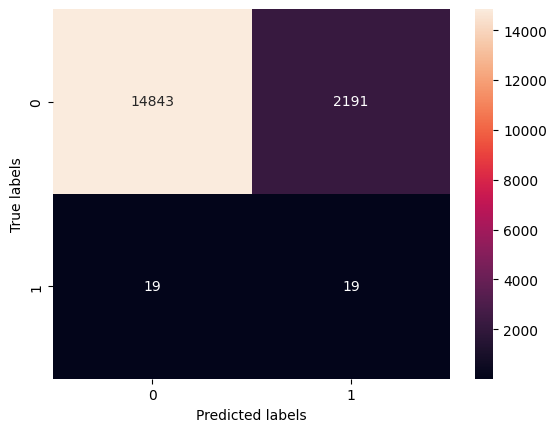

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_test, annot=True, fmt = 'd')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [ ]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': x_training.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance = feature_importance.reindex(feature_importance['Importance'].abs().sort_values(ascending=False).index)

In [ ]:
print("Coefficients and Odds Ratios:")
feature_importance.head(20)

Coefficients and Odds Ratios:


,Feature,Importance
26,CONTRIBUTING FACTOR VEHICLE 1_Illnes,9.033340
66,CONTRIBUTING FACTOR VEHICLE 2_Driver Inexperience,6.603747
510,VEHICLE TYPE CODE 2_Taxi,6.037574
471,VEHICLE TYPE CODE 2_Pick-up Truck,5.651870
55,CONTRIBUTING FACTOR VEHICLE 1_Unsafe Speed,5.251201
378,VEHICLE TYPE CODE 2_E-Scooter,5.063273
65,CONTRIBUTING FACTOR VEHICLE 2_Driver Inattenti...,4.968711
52,CONTRIBUTING FACTOR VEHICLE 1_Traffic Control ...,4.728399
375,VEHICLE TYPE CODE 2_E-Bike,4.607881
59,CONTRIBUTING FACTOR VEHICLE 1_View Obstructed/...,4.583002


####d) Propensity Injured Accident

In [ ]:
# Set account_id as index of the propensity2
df_propensity = df_preparation.copy()
df_propensity = df_propensity.set_index('COLLISION_ID')
df_propensity

# untuk converting str to numeric (encoding) can use the get_dummies
df_propensity = pd.get_dummies(df_propensity, columns = categorical_columns) #drop_first = 'if_binary'

df_propensity['target'] = df_propensity['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x > 0 else 0)
label_column = ['target']

In [ ]:
feature_columns = list(set(df_propensity.columns) - set(label_column))
feature_columns = sorted(feature_columns)

features = df_propensity[feature_columns]
label = df_propensity[label_column]

In [ ]:
# Split into training and test dataset menggunakan train_test_split
x_training, x_test, y_training, y_test = train_test_split(features, label, test_size = 0.3, random_state=42)

In [ ]:
# Check split result
for df in [x_training, x_test, y_training, y_test]:
  print(df.shape)

(39832, 595)
(17072, 595)
(39832, 1)
(17072, 1)


In [ ]:
# Let's combine training and test data in 1 df
training = pd.concat([x_training, y_training], axis=1)
test = pd.concat([x_test, y_test], axis=1)

In [ ]:
pd.concat([x_training, y_training], axis=1)

,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,CONTRIBUTING FACTOR VEHICLE 1_-,CONTRIBUTING FACTOR VEHICLE 1_Accelerator Defective,CONTRIBUTING FACTOR VEHICLE 1_Aggressive Driving/Road Rage,CONTRIBUTING FACTOR VEHICLE 1_Alcohol Involvement,CONTRIBUTING FACTOR VEHICLE 1_Animals Action,...,VEHICLE TYPE CODE 2_tow truck,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_trailor,VEHICLE TYPE CODE 2_truck,VEHICLE TYPE CODE 2_uhaul truc,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_usps,VEHICLE TYPE CODE 2_utility,VEHICLE TYPE CODE 2_van,target
COLLISION_ID,,,,,,,,,,,,,,,,,,,,,
4336741,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4319465,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4309210,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4272148,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4312684,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271389,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4292248,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4341716,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#copy this manually from correlation proses above, to add some additional columns
#additional columns, drop this columns because this columns equals to the fatal / injured label for our target test
#'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',

to_drop = [ 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
  'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 2_-',
 'CONTRIBUTING FACTOR VEHICLE 2_Traffic Control Device Improper/Non-Working',
 'CONTRIBUTING FACTOR VEHICLE 2_Unspecified',
 'VEHICLE TYPE CODE 1_FIRE ENGIN',
 'VEHICLE TYPE CODE 1_Station Wagon/Sport Utility Vehicle',
 'VEHICLE TYPE CODE 2_-',
 'VEHICLE TYPE CODE 2_Amb',
 'VEHICLE TYPE CODE 2_Bike',
 'STREET ACCIDENT TYPE_ON CROSS STREET']

x_training = x_training.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)

In [ ]:
model = LogisticRegression(class_weight='balanced',max_iter= 500)
model.fit(x_training, y_training['target'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500)

In [ ]:
# Accuracy dr prediksi model dengan data training
model.score(x_training, y_training)

0.7264762000401687

In [ ]:
# Accuracy dr prediksi model dengan data test
model.score(x_test, y_test)

0.7193064667291471

In [ ]:
confusion_test = confusion_matrix(y_test, model.predict(x_test))
confusion_test

array([[8613, 3091],
       [1701, 3667]])

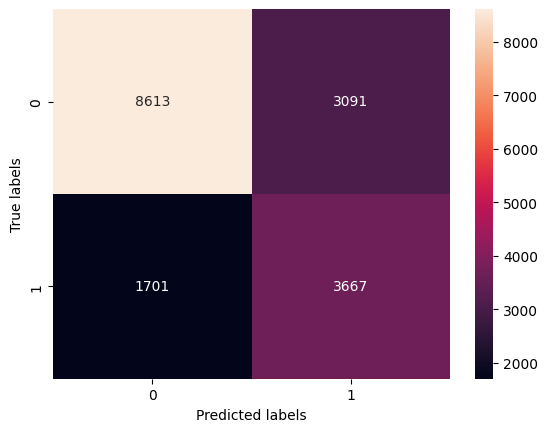

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_test, annot=True, fmt = 'd')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [ ]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': x_training.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance = feature_importance.reindex(feature_importance['Importance'].abs().sort_values(ascending=False).index)

In [ ]:
print("Coefficients and Odds Ratios:")
feature_importance.head(20)

Coefficients and Odds Ratios:


,Feature,Importance
123,VEHICLE TYPE CODE 1_Bike,2.730112
160,VEHICLE TYPE CODE 1_E-Scooter,2.386509
159,VEHICLE TYPE CODE 1_E-Bike,2.199505
343,VEHICLE TYPE CODE 2_Ambulance,2.125221
222,VEHICLE TYPE CODE 1_Moped,1.949327
29,CONTRIBUTING FACTOR VEHICLE 1_Lost Consciousness,1.882286
5,CONTRIBUTING FACTOR VEHICLE 1_-,1.837540
350,VEHICLE TYPE CODE 2_Box Truck,1.803701
335,VEHICLE TYPE CODE 2_4 dr sedan,1.772281
461,VEHICLE TYPE CODE 2_PK,1.753037
